In [10]:
! pip install mujoco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 30.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.0 MB/s eta 0:00:00:00:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T

from torch.distributions import Categorical
import numpy as np
import pandas as pd
import gym

from collections import deque
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Bad pipe message: %s [b"\x15U^\x16\xe3\xf6A\x1cg\x14\xf5\x17\xc4\x01\xea S_ \x1b\xa1\xce/t\x93'\x92\xcb\xe9\xfa\xa2\xdb"]
Bad pipe message: %s [b'\xc9\xd1\x10\x88tR\x01#\x18\x84;\xf4\x88\xa1\x97C\x04\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00']
Bad pipe message: %s [b'\xc2\x98\x96\xfcdk\x0b\xf8\xac=\x95\xf5\x01O\xf5\x00\xf1=\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x004\x00\x9b\x00F\xc0\x0e\xc0\x04\x00/\x00\x96\x00A\x00\x07\xc0\x11\xc0\x07\xc0\x16\x00\x18\xc0\x0c\xc0\x02\x00\x05\x00\x04\xc0\x12\xc0\x08\x00\x16\x00']
Bad pipe message: %s [b"\x0c\x10|\x04\xe0\xe5M\x07\xb4 \xaf \xb6\x1ci\xecq\xa5\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc

In [2]:
class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=256)
        self.linear3 = nn.Linear(in_features=256, out_features=output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        output = F.softmax(x, dim=-1)
        return output

class Critic(nn.Module):
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=256)
        self.linear3 = nn.Linear(in_features=256, out_features=output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        output = self.linear3(x)
        return output

In [3]:


class ActorCritic():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 5000
      self.max_steps = 1000
      self.gamma = 0.99
      self.epsilon = 1.0
      self.epsilon_min = 0.001
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 120
      self.replay_buffer_capacity=5000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
      # _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      self.state_count = env.observation_space.shape[0]
      self.action_count = env.action_space.n
      self.actor = Actor(self.state_count, self.action_count)
      self.critic = Critic(self.state_count, 1)#self.action_count) 
      # self.critic_av = Critic(self.state_count, self.action_count) 
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.00008)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.00008)
      self.loss_func = F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./actor.pth"
    
    def choose_action(self, state, test=False):
      if not test:
          action_prob = self.actor(state)
          actions_cat = Categorical(action_prob)

          current_action = actions_cat.sample()
          action_log_prob = actions_cat.log_prob(current_action)
          return current_action, action_log_prob
      else:
          return self.get_q_value_for_state(state)#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.actor(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self):
      self.actor.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        current_state = torch.from_numpy(obs).unsqueeze(0) 
        while not done:
          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())
          self.env.render()
          
          reward_sum += curr_reward
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) 

          steps +=1
          
          current_state = next_state
          if steps==500 or reward_sum==470:
            done=True

        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self, current_state, reward, next_state, done, action_log_prob, I):
      
      current_state_val = self.critic(current_state)
      next_state_val = self.critic(next_state) if not done else 0
  
      delta = reward + self.gamma*next_state_val - current_state_val
      actor_loss = (-1*action_log_prob*delta.item()*I)
      critic_loss = (delta**2)
      # print(actor_loss, critic_loss)
      self.actor_optimizer.zero_grad()
      self.critic_optimizer.zero_grad()
      
      loss = actor_loss+critic_loss
      # (actor_loss + critic_loss).backward()
      # actor_loss.backward()
      loss.backward()
      for param in self.actor.parameters():
          param.grad.data.clamp_(-1, 1)
      for param in self.critic.parameters():
          param.grad.data.clamp_(-1, 1)
      
      self.actor_optimizer.step()
      self.critic_optimizer.step()

      return actor_loss.item(), critic_loss.item()
      
    def learn(self):
      
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        a_running_loss=0
        c_running_loss=0
        I = 1
        current_state = torch.from_numpy(obs).unsqueeze(0)
        while not done:
          current_action, action_log_prob = self.choose_action(current_state)

          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())

          reward_sum += curr_reward
          
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) 
  
          actor_loss, critic_loss = self.train(current_state, curr_reward, next_state, done, action_log_prob, I)
          I = self.gamma*I
          steps +=1
          # print(actor_loss,critic_loss)
          a_running_loss += actor_loss
          c_running_loss += critic_loss
          current_state = next_state

          if steps==self.max_steps:# or reward_sum==470:
            done=True

        # self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda)
      
        if episode % 100 == 99:
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | loss: {a_running_loss / 10:.3f}, {c_running_loss / 10:.3f}')
          a_running_loss = 0.0
          c_running_loss = 0.0
          self.env.render()
          if sum(self.rewards_list[-100:])/100 >= 200:
            break
          # p.print()
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.critic.load_state_dict(self.actor.state_dict())
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
      current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)



In [4]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
# env = gym.make("Ant-v4")
env.reset()
agent = ActorCritic(env)
agent.learn()

/tmp/ipykernel_7936/3114582093.py:17: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(84, interpolation=Image.CUBIC),
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
  2%|▏         | 100/5000 [01:47<3:21:31,  2.47s/episodes]

[Episode: 100] - Steps: 235.75 | Rewards: -198.61579643777384 | loss: -1.576, 594.542


  4%|▍         | 200/5000 [05:25<4:30:08,  3.38s/episodes]

[Episode: 200] - Steps: 437.13 | Rewards: -39.36767959195328 | loss: 0.621, 136.931


  6%|▌         | 300/5000 [09:20<2:21:33,  1.81s/episodes]

[Episode: 300] - Steps: 458.0 | Rewards: 20.072517541707327 | loss: 0.058, 840.962


  8%|▊         | 400/5000 [13:00<5:15:45,  4.12s/episodes]

[Episode: 400] - Steps: 399.02 | Rewards: 25.7999196985824 | loss: -0.733, 31.705


 10%|█         | 500/5000 [16:20<2:01:01,  1.61s/episodes]

[Episode: 500] - Steps: 362.57 | Rewards: 24.061469331625894 | loss: -0.841, 1361.300


 12%|█▏        | 600/5000 [19:07<1:15:00,  1.02s/episodes]

[Episode: 600] - Steps: 316.97 | Rewards: 23.76949387779254 | loss: -1.599, 878.569


 14%|█▍        | 700/5000 [22:26<1:54:30,  1.60s/episodes]

[Episode: 700] - Steps: 369.59 | Rewards: 37.45841647010126 | loss: -0.843, 1390.766


 16%|█▌        | 800/5000 [24:43<3:24:14,  2.92s/episodes]

[Episode: 800] - Steps: 269.2 | Rewards: 78.70398374837173 | loss: -1.374, 50.506


 18%|█▊        | 900/5000 [27:06<1:20:57,  1.18s/episodes]

[Episode: 900] - Steps: 278.95 | Rewards: 84.19895186798718 | loss: -0.018, 1164.930


 20%|██        | 1000/5000 [30:37<1:13:03,  1.10s/episodes]

[Episode: 1000] - Steps: 410.52 | Rewards: 107.36570954017836 | loss: -2.125, 1563.687


 22%|██▏       | 1100/5000 [32:40<29:19,  2.22episodes/s]  

[Episode: 1100] - Steps: 258.3 | Rewards: 96.58512573788742 | loss: 0.092, 2636.837


 24%|██▍       | 1200/5000 [34:44<53:18,  1.19episodes/s]  

[Episode: 1200] - Steps: 259.28 | Rewards: 101.36043886222835 | loss: -0.323, 1103.345


 26%|██▌       | 1300/5000 [36:48<44:42,  1.38episodes/s]  

[Episode: 1300] - Steps: 263.13 | Rewards: 88.33145768467824 | loss: 0.681, 1083.486


 28%|██▊       | 1380/5000 [38:02<19:02,  3.17episodes/s]  

In [21]:
PATH = './actor.pth'
torch.save(agent.actor.state_dict(), PATH)

In [22]:
PATH = './critic.pth'
torch.save(agent.critic.state_dict(), PATH)

In [7]:
epsilon_list_train_dqn = agent.epsilon_list
reward_list_train_dqn = agent.rewards_list

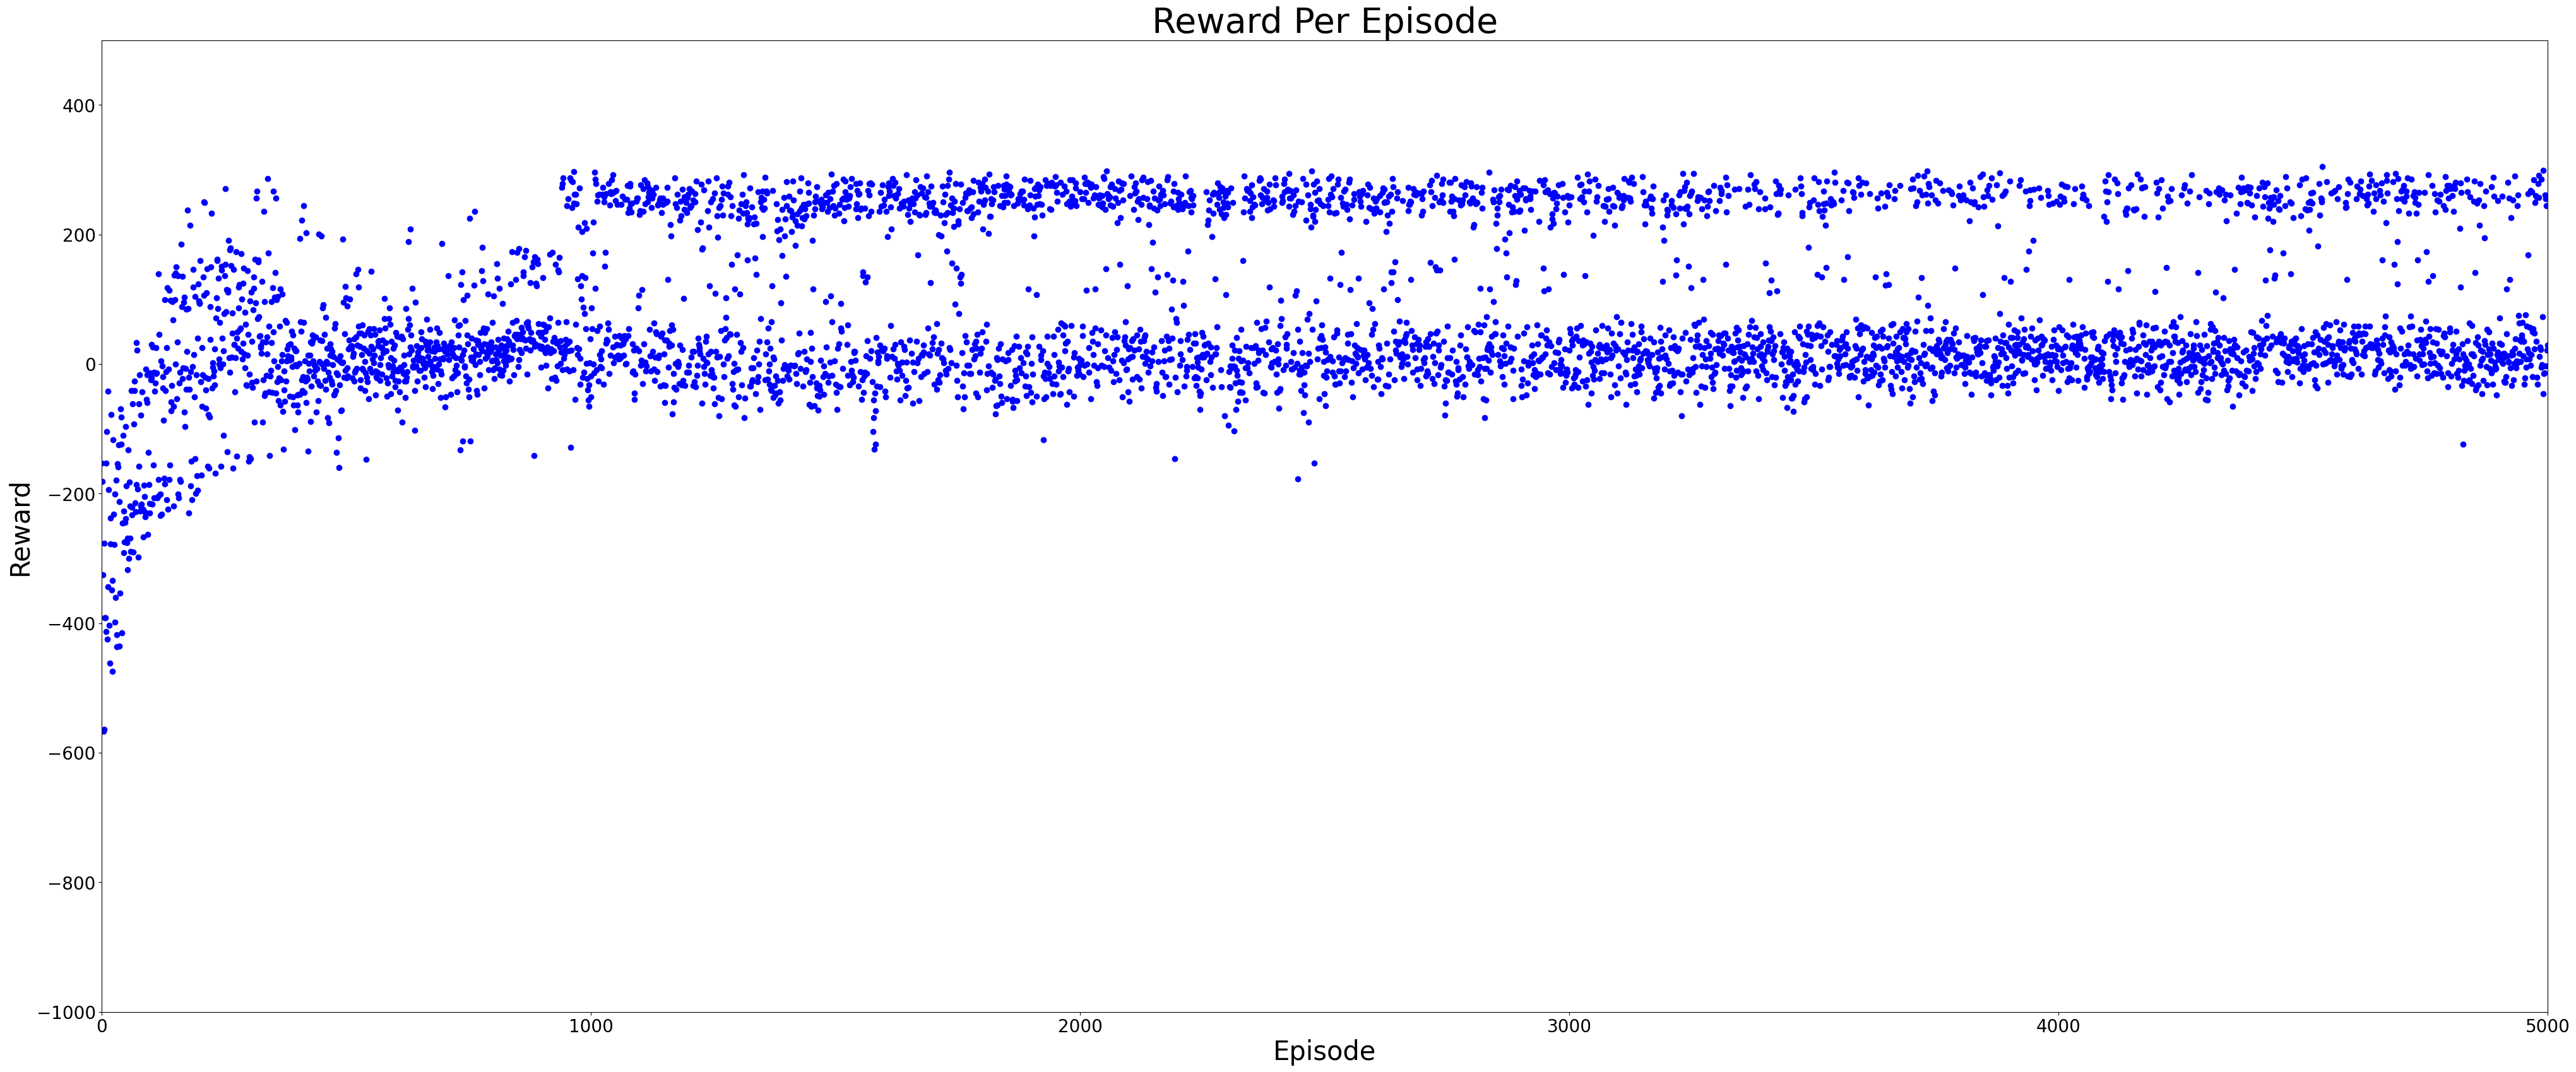

In [8]:
fig, (ax2) = plt.subplots(1,1)
fig.set_figheight(20)
fig.set_figwidth(50)
# ax1.plot(epsilon_list_train_dqn, 'go')
# ax1.set_title("Epsilon Decay", size=40)
# ax1.set_ylabel('Epsilon Value', fontsize = 30) 
# ax1.set_xlabel('Episode', fontsize = 30)
# ax1.tick_params(axis='x', labelsize=20)
# ax1.tick_params(axis='y', labelsize=20)
# ax1.set_xlim(100)
# ax1.set_xlim(xmin=0, xmax=3800)
# ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=5000)
ax2.set_ylim(ymin=-1000, ymax=500)
plt.show()

In [9]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 50):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))


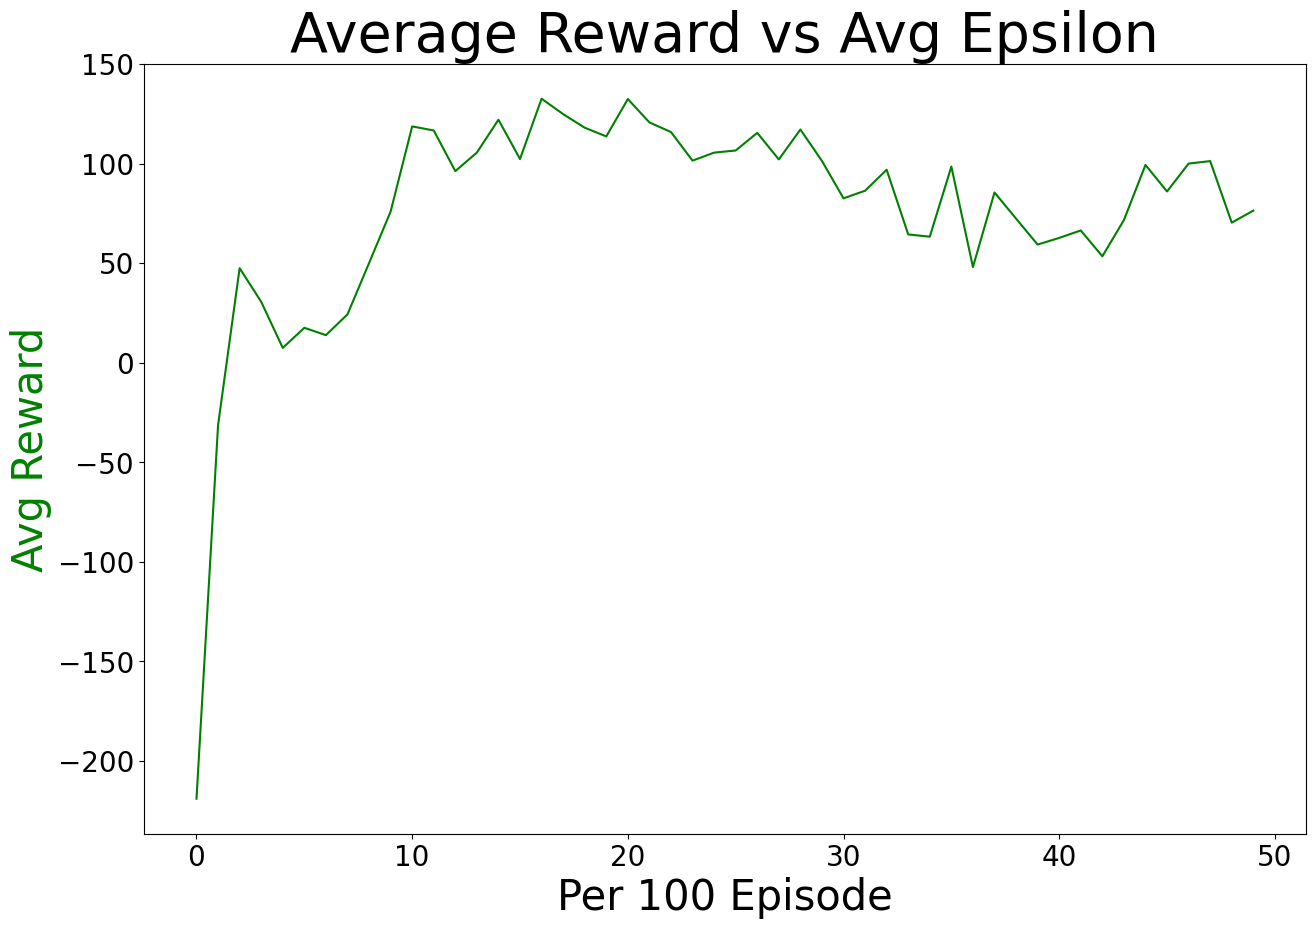

In [10]:
fig, ax2 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax2.set_title("Average Reward vs Avg Epsilon", size=40)
ax2.set_xlabel('Per 100 Episode', fontsize=30)
ax2.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [ ]:
import json
with open('reward.json', 'w') as f:
    json.dump(reward_list_train_dqn, f)

# import json
# with open('backup/epsilon.json') as f:
#     epsilon_list_train_dqn = json.load(f)

In [11]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset()
agent_test = ActorCritic(env)
agent_test.eval()

/tmp/ipykernel_3763/2592339016.py:17: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(84, interpolation=Image.CUBIC),
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


RuntimeError: Error(s) in loading state_dict for Actor:
	size mismatch for linear1.weight: copying a param with shape torch.Size([300, 4]) from checkpoint, the shape in current model is torch.Size([128, 4]).
	size mismatch for linear1.bias: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for linear2.weight: copying a param with shape torch.Size([300, 300]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for linear2.bias: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for linear3.weight: copying a param with shape torch.Size([2, 300]) from checkpoint, the shape in current model is torch.Size([2, 256]).

In [6]:
reward_list_test_dqn = agent_test.test_rewards_list

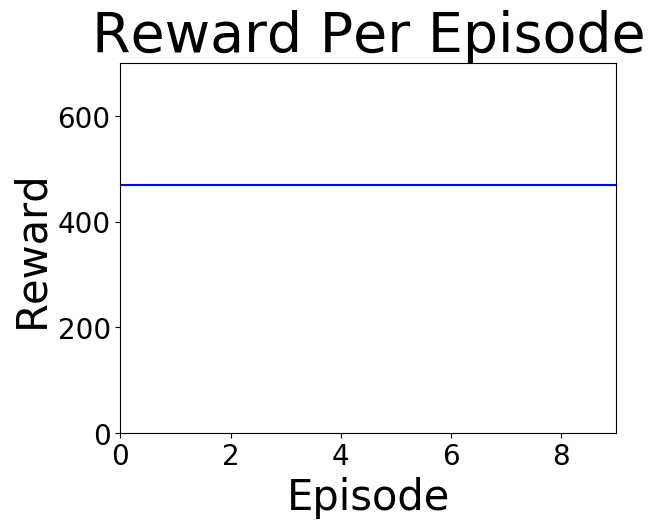

In [12]:
fig, (ax2) = plt.subplots(1,1)
# fig.set_figheight(50)
# fig.set_figwidth(50)
# ax1.plot(epsilon_list_train_dqn, 'go')
# ax1.set_title("Epsilon Decay", size=40)
# ax1.set_ylabel('Epsilon Value', fontsize = 30) 
# ax1.set_xlabel('Episode', fontsize = 30)
# ax1.tick_params(axis='x', labelsize=20)
# ax1.tick_params(axis='y', labelsize=20)
# ax1.set_xlim(100)
# ax1.set_xlim(xmin=0, xmax=3800)
# ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_test_dqn, 'b-')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=9)
ax2.set_ylim(ymin=0, ymax=700)
plt.show()